### Applying Model Agnostic Interpretation to Ensemble Models

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# Reference for customizing matplotlib: https://matplotlib.org/users/style_sheets.html
plt.style.use('ggplot')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel


data = load_breast_cancer()
# Description of the data
print(data.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

### Lets build an Ensemble of hetrogeneous Models

In [2]:
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf = eclf.fit(X, y)

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)

models = {'lr':clf1, 
          'rf':clf2, 
          'gnb':clf3, 
          'vt':eclf}

### How can we interpret or explain an Ensemble Model ? 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

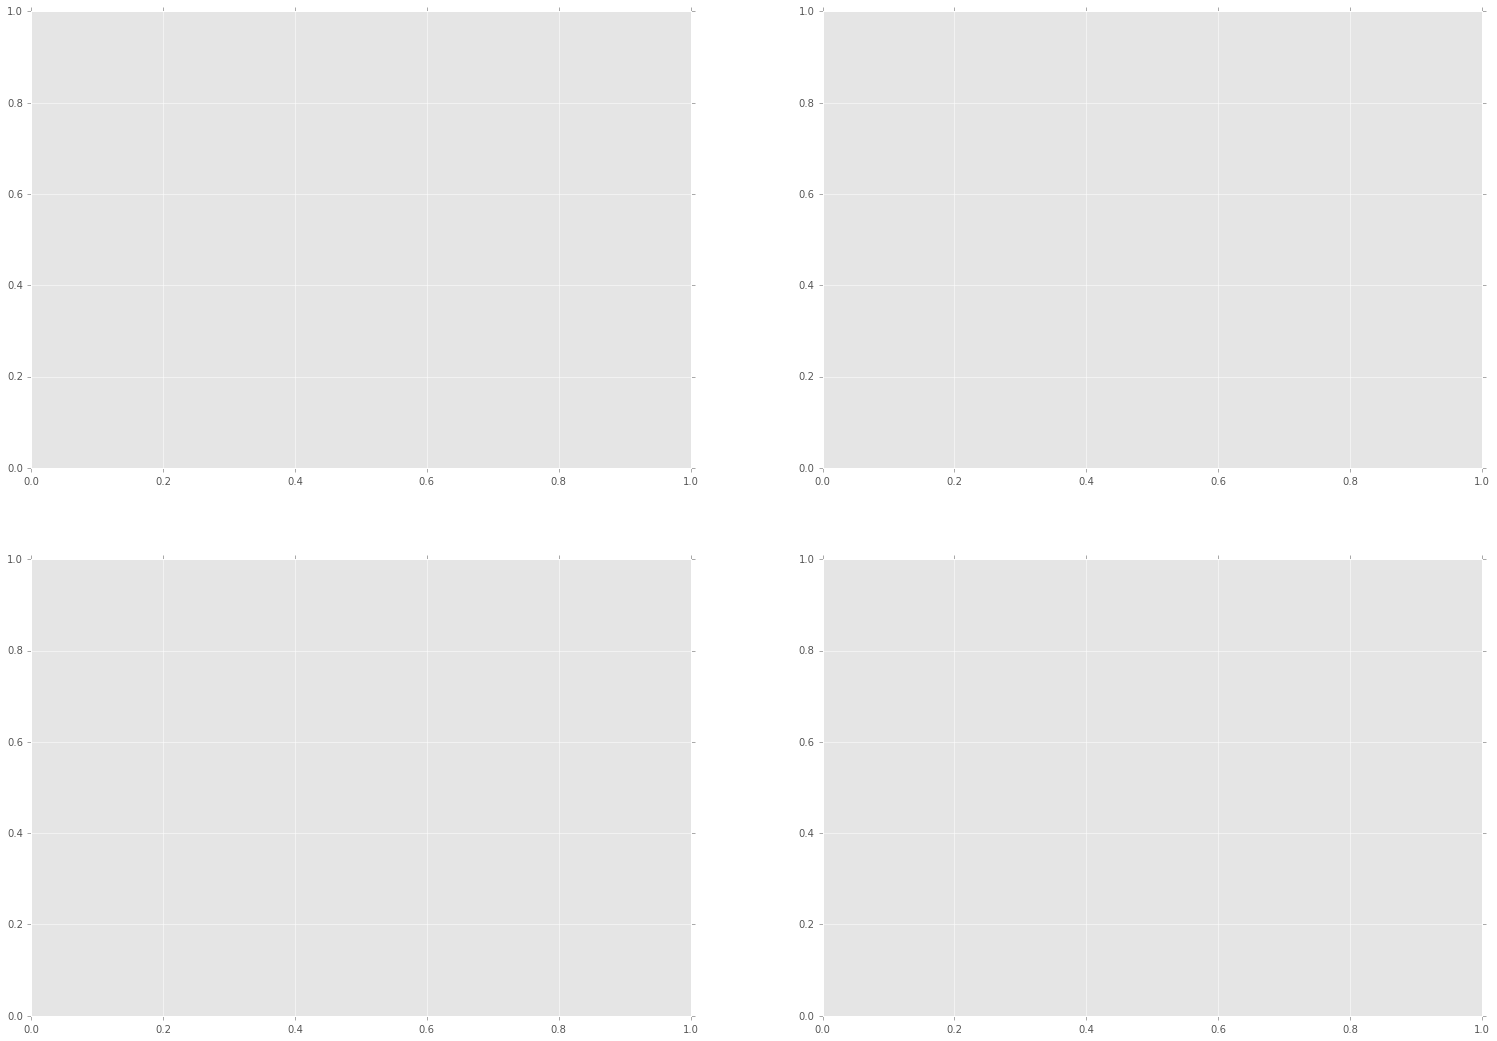

In [3]:
# Ensemble Classifier does not have feature importance enabled by default
f, axes = plt.subplots(2, 2, figsize = (26, 18))

ax_dict = {
    'lr':axes[0][0],
    'rf':axes[1][0],
    'gnb':axes[0][1],
    'vt':axes[1][1]
}

interpreter = Interpretation(X_test, feature_names=data.feature_names)

for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_test)
    ax = ax_dict[model_key]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ax=ax)
    ax.set_title(model_key)

In [ ]:
pyint_model = InMemoryModel(eclf.predict_proba, examples=X_test, target_names=data.target_names)
axes_list = interpreter.partial_dependence.plot_partial_dependence([('worst area', 'mean perimeter')],
                                                                       pyint_model, 
                                                                       grid_resolution=30, 
                                                                       with_variance=True)

### To Evaluate a point locally, lets apply Local Interpretation

In [ ]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(X_test, 
                           feature_names=data.feature_names, 
                           discretize_continuous=False, 
                           class_names=['p(No Cancer)', 'p(Cancer)'])

print(type(X_test[0]))
# Lets evaluate the prediction from the model and actual target label
print("prediction from the model:{}".format(eclf.predict(X_test[0])))
print("Target Label on the row:{}".format(y_test[0]))

#print(type(X_test[0]))
#exp.explain_instance(X_test[0], models['vt'].predict_proba).show_in_notebook()

## Conclusion:

While evaluating the model response locally we realize that even the Ensemble model predicted the above mentioned row in-correctly. But, one is able to know why by locally inspecting the predicted row. This inspection reveals that the 'mean radius' is playing a significant part in driving the correct response. This when mapped to global interpretation using Feature Importance across helps us in understanding more about the variable weighting used by the predictive model. We can further look into it, using partial dependence plots and understand the influence of `mean radius` on the targeted prediction.

In [ ]:
pyint_model = InMemoryModel(eclf.predict_proba, examples=X_test, target_names=data.target_names)
axes_list = interpreter.partial_dependence.plot_partial_dependence(['mean radius'],
                                                                       pyint_model, 
                                                                       grid_resolution=30, 
                                                                       with_variance=True)